In [1]:
##### Copyright 2021 The Cirq Developers

In [2]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Identifying Hardware Changes

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/google/identifying_hardware_changes"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/main/docs/tutorials/google/identifying_hardware_changes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/main/docs/tutorials/google/identifying_hardware_changes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/google/identifying_hardware_changes.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

You've run your circuit with Google's [Quantum Computing Service](./start.ipynb) and you're getting results that unexpectedly differ from those you saw when you ran your experiment last week. What's the cause of this and what can you do about it?

Your experience may be due to changes in the device that have occurred since the most recent maintenance calibration. Every few days, the QCS devices are calibrated for the highest performance across all of their available qubits and operations. However, in the hours or days since the most recent maintenance calibration, the performance of the device hardware may have changed significantly, affecting your circuit's results.  

The rest of this tutorial will describe these hardware changes, demonstrate how to collect error metrics for identifying if changes have occurred, and provide some examples of how you can compare your metric results to select the most performant qubits for your circuit.
For more further reading on qubit picking methodology, see the [Best Practices](../../google/best_practices.ipynb) guide and [Qubit Picking with Loschmidt Echoes](./echoes.ipynb) tutorial. The method presented in the Loschmidt Echoes tutorial is an alternative way to identify hardware changes.

## Hardware Changes

The device hardware changes occur in both the qubits themselves and the control electronics used to drive gates and measure the state of the qubits. As analog devices, both the qubits and control electronics are subject to interactions with their environment that manifest as a meaningful change to the qubits gate or readout fidelity.

Quantum processors based on frequency tunable [superconducting qubits](https://en.wikipedia.org/wiki/Superconducting_quantum_computing) use a [direct current (DC) bias](https://en.wikipedia.org/wiki/DC_bias) current to set the frequency of the qubits' $|0\rangle$ state to $|1\rangle$ state transition. These DC biases are generated by classical analog control electronics, where resistors and other components can be affected by environmental temperature changes in an interaction called thermal drift. Uncompensated thermal drift results in a change in the qubit's transition frequency, which can cause unintended state transitions in the qubits during circuit execution or incorrect readout of the qubits' state. These manifest as changes to the error rates associated with gate and readout operations.

Additionally, the qubits may unexpectedly couple to other local energy systems and exchange energy with or lose energy to them. Because a qubit is only able to identify the presence of two levels in the parasitic local system, these interacting states are often referred to as [two-level systems (TLS)](https://en.wikipedia.org/wiki/Two-state_quantum_system). While the exact physical origin of these states is unknown, defects in the hardware materials are a plausible explanation. It has been observed that interactions with these TLS can result in coherence fluctuations in time and frequency, again causing unintended state transitions or incorrect readouts, affecting error rates.

For more information on DC Bias and TLS and how they affect the devices, see [arXiv:1809.01043](https://arxiv.org/abs/1809.01043).

## Data Collection

### Setup

First, install Cirq and import the necessary packages.


In [3]:
try:
    import cirq
except ImportError:
    !pip install --quiet cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 56.2 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import cirq
import cirq_google as cg

Next, authorize to use the Quantum Computing Service with a `project_id` and `processor_id`, and get a sampler to run your experiments. Set the number of repetitions you'll use for all experiments.

Note: You can select a subset of the qubits to shorten the runtime of the experiment.

Note: You need to input a real QCS project_id and processor_id in the next cell. Otherwise, the code will assume you're running with a simulator, causing issues later.

In [10]:
from cirq_google.engine.qcs_notebook import get_qcs_objects_for_notebook

# Set key variables
project_id = "your_project_id_here"  # @param {type:"string"}
processor_id = "your_processor_id_here"  # @param {type:"string"}
repetitions = 2000  # @param {type:"integer"}

# Get device sampler
qcs_objects = get_qcs_objects_for_notebook(project_id=project_id, processor_id=processor_id)

device = qcs_objects.device
sampler = qcs_objects.sampler

# Get qubit set
qubits = device.metadata.qubit_set

# Limit device qubits to only those before row/column `device_limit`
device_limit = 10  # @param {type:"integer"}
qubits = {qb for qb in qubits if qb.row < device_limit and qb.col < device_limit}

print(qubits)

Getting OAuth2 credentials.
Press enter after entering the verification code.
None
Authentication complete.
{cirq.GridQubit(4, 2), cirq.GridQubit(5, 2), cirq.GridQubit(6, 2), cirq.GridQubit(7, 2), cirq.GridQubit(8, 2), cirq.GridQubit(3, 4), cirq.GridQubit(2, 4), cirq.GridQubit(5, 4), cirq.GridQubit(6, 4), cirq.GridQubit(7, 4), cirq.GridQubit(4, 4), cirq.GridQubit(3, 6), cirq.GridQubit(4, 6), cirq.GridQubit(5, 6), cirq.GridQubit(9, 4), cirq.GridQubit(7, 6), cirq.GridQubit(8, 6), cirq.GridQubit(8, 4), cirq.GridQubit(4, 8), cirq.GridQubit(5, 8), cirq.GridQubit(6, 8), cirq.GridQubit(9, 6), cirq.GridQubit(8, 8), cirq.GridQubit(7, 8), cirq.GridQubit(6, 1), cirq.GridQubit(7, 1), cirq.GridQubit(3, 3), cirq.GridQubit(4, 3), cirq.GridQubit(5, 3), cirq.GridQubit(6, 3), cirq.GridQubit(7, 3), cirq.GridQubit(8, 3), cirq.GridQubit(9, 3), cirq.GridQubit(2, 5), cirq.GridQubit(4, 5), cirq.GridQubit(3, 5), cirq.GridQubit(7, 5), cirq.GridQubit(6, 5), cirq.GridQubit(5, 5), cirq.GridQubit(4, 7), cirq.GridQu

### Current Two-Qubit Metric Data with XEB

This section is a shortened version of the [Parallel XEB](../../noise/qcvv/parallel_xeb.ipynb) tutorial, which runs characterization experiments to collect data for the `two_qubit_parallel_sqrt_iswap_gate_xeb_pauli_error_per_cycle` metric. First, generate a library of two qubit circuits using the $\sqrt{i\mathrm{SWAP}}$ gate . These circuits will be run in parallel in larger circuits according to `combinations_by_layer`.

In [13]:
"""Setup for parallel XEB experiment."""

from cirq.experiments import random_quantum_circuit_generation as rqcg
from itertools import combinations

random_seed = 52

# Generate library of two-qubit XEB circuits.
circuit_library = rqcg.generate_library_of_2q_circuits(
    n_library_circuits=20, two_qubit_gate=cirq.CZ, random_state=random_seed
)

device_graph = nx.Graph((q1, q2) for (q1, q2) in combinations(qubits, 2) if q1.is_adjacent(q2))

# Generate different possible pairs of qubits, and randomly assign circuit (indices) to then, n_combinations times.
combinations_by_layer = rqcg.get_random_combinations_for_device(
    n_library_circuits=len(circuit_library),
    n_combinations=10,
    device_graph=device_graph,
    random_state=random_seed,
)
# Prepare the circuit depths the circuits will be truncated to.
cycle_depths = np.arange(3, 100, 20)

Then, run the circuits on the device, combining them into larger circuits and truncating the circuits by length, with `cirq.experiments.xeb_sampling.sample_2q_xeb_circuits`.

Afterwards, run the same circuits on a perfect simulator, and compare them to the sampled results. Finally, fit the collected data to an exponential decay curve to estimate the error rate per appication of each two-qubit $\sqrt{i\mathrm{SWAP}}$ gate.

In [14]:
"""Collect all data by executing circuits."""

from cirq.experiments.xeb_sampling import sample_2q_xeb_circuits
from cirq.experiments.xeb_fitting import benchmark_2q_xeb_fidelities, fit_exponential_decays

# Run XEB circuits on the processor.
sampled_df = sample_2q_xeb_circuits(
    sampler=sampler,
    circuits=circuit_library,
    cycle_depths=cycle_depths,
    combinations_by_layer=combinations_by_layer,
    shuffle=np.random.RandomState(random_seed),
    repetitions=repetitions,
)

# Run XEB circuits on a simulator and fit exponential decays to get fidelities.
fidelity_data = benchmark_2q_xeb_fidelities(
    sampled_df=sampled_df, circuits=circuit_library, cycle_depths=cycle_depths
)
fidelities = fit_exponential_decays(fidelity_data)

# Grab (pair, sqrt_iswap_pauli_error_per_cycle) data for all qubit pairs.
pxeb_results = {
    pair: (1.0 - fidelity) / (4 / 3)  # Scalar to get Pauli error
    for (_, _, pair), fidelity in fidelities.layer_fid.items()
}

100%|██████████| 207/207 [06:21<00:00,  1.84s/it]


Note: The parallel XEB errors are scaled in pxeb_results. This is because the collected fidelities are the estimated depolarization fidelities, not the Pauli error metrics available from the calibration data. See the [XEB Theory](../../noise/qcvv/xeb_theory.ipynb#fidelities) tutorial for an explanation of why.

### Current Readout Metric Data with Simultaneous Readout

To evaluate performance changes in the readout registers, collect the Parallel P11 error data for each qubit with the Simultaneous Readout experiment, accessible with `cirq.estimate_parallel_single_qubit_readout_errors`. This function runs the experiment to estimate P00 and P11 errors for each qubit (as opposed to querying for the most recent calibration data). The experiment prepares each qubit in the $|0\rangle$ and $|1\rangle$ states, measures them, and evaluates how often the qubits are measured in the expected state.

In [15]:
# Run experiment
sq_result = cirq.estimate_parallel_single_qubit_readout_errors(
    sampler, qubits=qubits, repetitions=repetitions
)

# Use P11 errors
p11_results = sq_result.one_state_errors

## Heatmap Comparisons

For each metric, plot the collected characterization data side by side using a heatmap to visualize the errors.

### Two-Qubit Metric Heatmap Comparison

(<Axes: title={'center': 'Current'}, xlabel='column', ylabel='row'>,
 <matplotlib.collections.PolyCollection at 0x7f149f5e5290>)

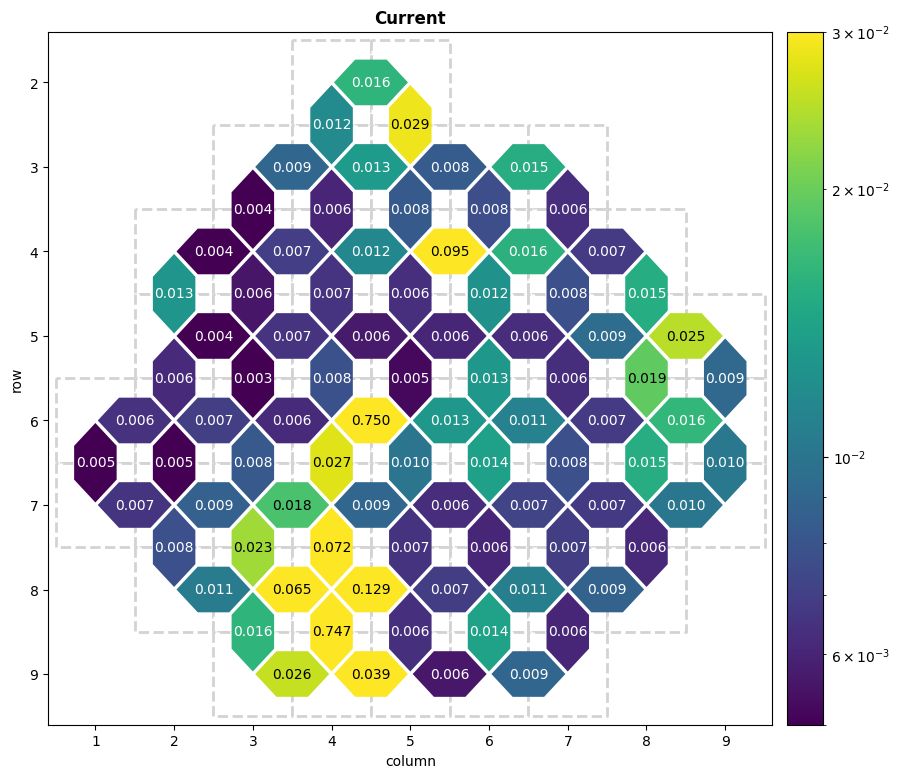

In [25]:
from matplotlib.colors import LogNorm

# Plot options. You may need to change these if you data shows a lot of the same colors.
vmin = 5e-3
vmax = 3e-2
options = {"norm": LogNorm()}
format = "0.3f"

fig, ax = plt.subplots(figsize=(10, 9))

# Current two qubit data
cirq.TwoQubitInteractionHeatmap(pxeb_results).plot(
    ax=ax,
    title="Current",
    vmin=vmin,
    vmax=vmax,
    collection_options=options,
    annotation_format=format,
)

The large numbers in yellow show where errors are very high.  For instance, qubits $(8,4)$ and $(9,4)$ have high errors and should be avoided.

It's important to note that, if you have the option to use a _consistently_ high reliablity qubit or qubit pair, instead of one that demonstrates inconsistent performance, you should do so.

### Readout Metric Heatmap Comparisons

(<Axes: title={'center': 'Current'}, xlabel='column', ylabel='row'>,
 <matplotlib.collections.PolyCollection at 0x7f14a0a75c50>)

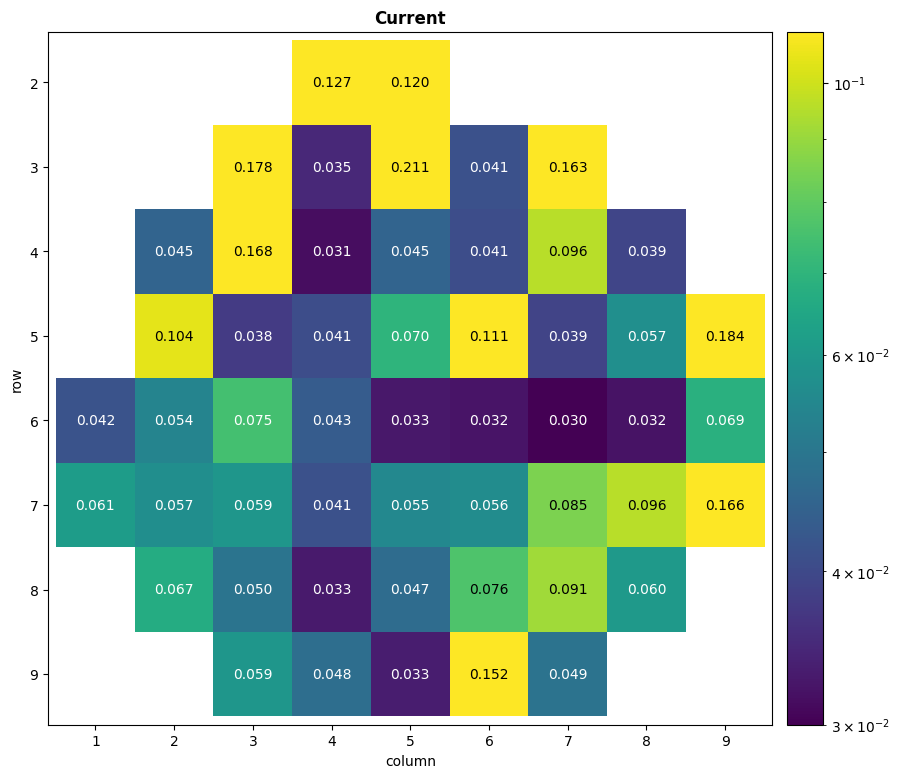

In [26]:
# Plot options, with different vmin and vmax for readout data.
vmin = 3e-2
vmax = 1.1e-1
options = {"norm": LogNorm()}
format = "0.3f"

fig, ax = plt.subplots(figsize=(10, 9))

# Current readout data
cirq.Heatmap(p11_results).plot(
    ax=ax,
    title="Current",
    vmin=vmin,
    vmax=vmax,
    collection_options=options,
    annotation_format=format,
)

The readout data demonstrates demonstrates more varying results than the two-qubit data. Many of the qubits have high readout errors, especially towards the sides of the processor.  These qubits should be avoided or at least, have errors mitigated.

Again, it is valuable to find reliable qubits that didn't demonstrate significant change.

Note: If your collected characterization data demonstrates that the device has changed vastly more than shown in these examples, the system may have become too far from the last calibration to be reasonably usable. In this case, please email the quantum engine support team to let them know.

## What's Next?

You've selected better candidate qubits for your circuit, based on updated information about the device. What else can you do for further improvements?

*    You need to map your actual circuit's logical qubits to your selected hardware qubits. This is in general a difficult problem, and the best solution can depend on the specific structure of the circuit to be run. Take a look at the [Qubit Picking with Loschmidt Echoes](./echoes.ipynb) tutorial, which estimates the error rates of gates for your specific circuit. Also, consider [Best Practices#qubit picking](../../google/best_practices.ipynb#qubit_picking) for additional advice on this.
*    The [Optimization, Alignment, and Spin Echoes](./spin_echoes.ipynb) tutorial provides resources on how you can improve the reliability of your circuit by: optimizing away redundant or low-impact gates, aligning gates into moments with others of the same type, and preventing decay on idle qubits with by adding spin echoes.
*    Other than for qubit picking, you should also use calibration for error compensation. The [Coherent vs incoherent noise with XEB](../../noise/qcvv/coherent_vs_incoherent_xeb.ipynb), [XEB Calibration Example](../../noise/qcvv/xeb_calibration_example.ipynb), [Parallel XEB](../../noise/qcvv/parallel_xeb.ipynb) and [Isolated XEB](../../noise/qcvv/isolated_xeb.ipynb) tutorials demonstrate how to run a classical optimizer on collected two-qubit gate characterization data, identity the true unitary matrix implemented by each gate, and add [Virtual Pauli Z gates](../../hardware/devices.ipynb) to compensate for the identified error, improving the reliability of your circuit.
*    You are also free to use the characterization data to improve the performance of large batches of experiment circuits. In this case you'd want to prepare your characterization ahead of running all your circuits, and use the data to compensate each circuit, right before running them.